## Import packages

In [65]:
import numpy as np
import numpy.matlib as npm
import matplotlib.pyplot as plt
import scipy.linalg
import scipy.stats
import time
import os

## Dataset

### Mushroom dataset

In [69]:
# Loading dataset (mushroom)
data = np.loadtxt('mushroom_dataset/agaricus-lepiota.data', delimiter=',', dtype=str) # load
attr = [{val: int(cnt) for cnt, val in enumerate(list(set(data[:,i])))} for i in range(len(data[0,:]))] # dict mapping
data = np.array([np.array([attr[i][e] for e in data[:,i]]) for i in range(len(data[0,:]))]).T # swap str to int

# Data preparation (Check columns)
cols = [i for i,e in enumerate(attr) if len(e)==1]
for col in cols:
    data = np.delete(data, col, axis=1)

# .ARFF save
with open('xor.arff', 'w') as f:
    f.write('@RELATION or\n')
    f.write('\n')
    f.write('@ATTRIBUTE x REAL\n')
    f.write('@ATTRIBUTE y REAL\n')
    f.write('@ATTRIBUTE class {1.0,0.0}\n')
    f.write('\n')
    f.write('@DATA\n')
    for d in data:
        f.write(','.join(d.astype(str)))
        f.write('\n')

### Xor dataset

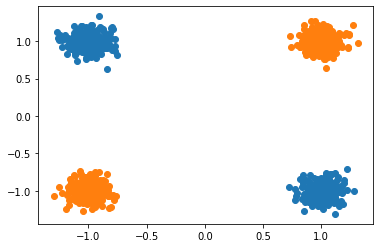

In [85]:
data = np.hstack( (np.loadtxt('xor_input.txt', dtype=float).T, np.loadtxt('x_or_target.txt', dtype=float).T.reshape(1000,1)) )

# with open('xor.arff', 'w') as f:
#     f.write('@RELATION or\n')
#     f.write('\n')
#     f.write('@ATTRIBUTE x REAL\n')
#     f.write('@ATTRIBUTE y REAL\n')
#     f.write('@ATTRIBUTE class {1.0,0.0}\n')
#     f.write('\n')
#     f.write('@DATA\n')
#     for d in data:
#         f.write(','.join(d.astype(str)))
#         f.write('\n')

for lb in set(data[:,2]):
    cond = np.where(data[:,2]==lb)
    plt.scatter(data[cond][:,0],data[cond][:,1])

### Standardize or Normalize dataset

In [71]:
data_attr = data[:,:-1]

### Standardization: (d - mean ) / std        [For each column]
data[:,:-1] = (data_attr - np.mean(data_attr, axis=0)) / np.std(data_attr, axis=0)

### Normalization  : (d - min) / (max - min)  [For each column]
# data[:,:-1] = ( data_attr - np.min(data_attr, axis=0) ) / ( np.max(data_attr, axis=0) - np.min(data_attr, axis=0) )

### Sum 1 to the last column (labels)
data[:,-1]+=1

## Classifiers

### LMQ - Linear dos Mínimos Quadrados

In [48]:
def LMQ_classifier(data, n_runs=100, p_train=0.8, silent=False, plot=True):
    # Variables
    name = 'LMQ'
    desc = 'Linear dos Mínimos Quadrados (LMQ)'
    if silent==False:
        print('> {}'.format(desc))

    # General variables
    N_samples = len(data)
    N_attribs = len(data[0])-1
    N_train   = round(p_train*N_samples)
    N_test    = N_samples-N_train
    K         = int(np.max(data[:,-1]))
    rates     = np.array([]) # Accuracys
    confusion = np.zeros((K,K))
    stats     = {}
    if silent==False:
        print('> The problem has {} classes'.format(K))
    
    # Loop of independent runs
    for loop in range(1, n_runs+1):
        ### Data preparation
        # Shuffle rows of the data matrix
        np.random.shuffle(data)

        # Split into training and tests subsets
        data_train = data[:N_train]
        data_test  = data[N_train:]

        # Partition of training data into attributes and label
        X_train = data_train[:,:-1]
        Y_train = data_train[:,-1]

        ### Training
        # Routine to convert numerical labels into binary (1-out-of-K) labels
        labels_train = np.zeros((N_train, K))
        labels = np.eye(K)
        for k in range(1,K+1):
            yK = np.where(Y_train[:] == k)
            labels_train[yK,:] = npm.repmat(labels[k-1,:], len(yK), 1)
        
        # Compute the weight matrix (N_attribs, N_samples)x(N_samples, N_labels) = (N_attribs, N_labels)
        W = np.matmul(np.linalg.pinv(X_train), labels_train)

        ### Testing
        # Begin test time
        correct = 0
        for i in range(0,N_test):
            X_test = data_test[i,:-1] # Test sample to be classified
            label_test = int(data_test[i,-1]) # Actual label of the test sample
            # Predict the output label (1, N_attribs) x (N_attribs, N_labels) = (1, N_labels)
            prediction = np.matmul(X_test, W)
            prediction_label = np.where( prediction==max(prediction) )[0][0] + 1
            if prediction_label==label_test:
                correct+=1 # hit
            confusion[prediction_label-1,label_test-1]+=1 # predicted x ground truth

        # Recognition rate of r-th run
        rates = np.append(rates, correct*100/N_test)
    
    ### Statistics
    # Get stats for each class
    def get_stats_each_class(confusion_matrix):
        stats_class = np.array([])
        lb = 0
        for lb in range(K):
            TP = confusion[lb,lb]
            FP = np.sum(confusion[lb,:])-confusion[lb,lb]
            FN = np.sum(confusion[:,lb])-confusion[lb,lb]
            TN = np.sum(confusion) - TP - FP - FN
            acc = (TP+TN)/(TP+TN+FP+FN)
            f1_score = 2*TP/(2*TP+FP+FN)
            stats_class = np.append(stats_class, {'acc': acc, 'f1_score': f1_score})
        return stats_class

    # Get geral stats
    stats['name']        = name
    stats['mean']        = np.mean(rates)
    stats['std']         = np.std(rates)
    stats['median']      = np.median(rates)
    stats['min']         = np.min(rates)
    stats['max']         = np.max(rates)
    stats['confusion']   = confusion
    stats['stats_class'] = get_stats_each_class(confusion)

    if silent==False:
        stats_msg = 'mean±std: {:.2f}±{:.2f} ||| median: {:.2f} ||| [min,max]: [{:.2f},{:.2f}]'.format(stats['mean'],stats['std'],stats['median'],stats['min'],stats['max'])
        print(stats_msg)
        if plot:
            plt.boxplot(rates)
            plt.suptitle('{}\n{} rounds'.format(desc, n_runs))
            plt.xlabel(stats_msg)
            plt.show()

    return stats

### AD - Adaline

> Adaline (AD)
> The problem has 2 classes
loop 1
Epoch: 1
Epoch: 2
Epoch: 3
Epoch: 4
Epoch: 5
Epoch: 6
Epoch: 7
Epoch: 8
Epoch: 9
100.0
loop 2
Epoch: 1
Epoch: 2
Epoch: 3
Epoch: 4
Epoch: 5
Epoch: 6
Epoch: 7
Epoch: 8
Epoch: 9
100.0
loop 3
Epoch: 1
Epoch: 2
Epoch: 3
Epoch: 4
Epoch: 5
Epoch: 6
Epoch: 7
Epoch: 8
Epoch: 9
100.0
loop 4
Epoch: 1
Epoch: 2
Epoch: 3
Epoch: 4
Epoch: 5
Epoch: 6
Epoch: 7
Epoch: 8
Epoch: 9
100.0
loop 5
Epoch: 1
Epoch: 2
Epoch: 3
Epoch: 4
Epoch: 5
Epoch: 6
Epoch: 7
Epoch: 8
Epoch: 9
100.0
loop 6
Epoch: 1
Epoch: 2
Epoch: 3
Epoch: 4
Epoch: 5
Epoch: 6
Epoch: 7
Epoch: 8
Epoch: 9
100.0
loop 7
Epoch: 1
Epoch: 2
Epoch: 3
Epoch: 4
Epoch: 5
Epoch: 6
Epoch: 7
Epoch: 8
Epoch: 9
100.0
loop 8
Epoch: 1
Epoch: 2
Epoch: 3
Epoch: 4
Epoch: 5
Epoch: 6
Epoch: 7
Epoch: 8
Epoch: 9
100.0
loop 9
Epoch: 1
Epoch: 2
Epoch: 3
Epoch: 4
Epoch: 5
Epoch: 6
Epoch: 7
Epoch: 8
Epoch: 9
100.0
loop 10
Epoch: 1
Epoch: 2
Epoch: 3
Epoch: 4
Epoch: 5
Epoch: 6
Epoch: 7
Epoch: 8
Epoch: 9
100.0
mean±std: 100.00

/var/folders/91/wbzn1hld0pg17bqf6r_lt1zw0000gn/T/ipykernel_23091/46064765.py:92: RuntimeWarning: invalid value encountered in double_scalars
  acc = (TP+TN)/(TP+TN+FP+FN)
/var/folders/91/wbzn1hld0pg17bqf6r_lt1zw0000gn/T/ipykernel_23091/46064765.py:93: RuntimeWarning: invalid value encountered in double_scalars
  f1_score = 2*TP/(2*TP+FP+FN)


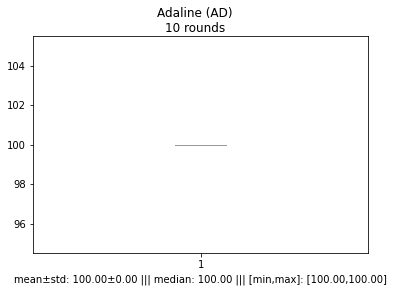

{'name': 'AD',
 'mean': 100.0,
 'std': 0.0,
 'median': 100.0,
 'min': 100.0,
 'max': 100.0,
 'confusion': array([[0., 0.],
        [0., 0.]]),
 'stats_class': array([{'acc': nan, 'f1_score': nan}, {'acc': nan, 'f1_score': nan}],
       dtype=object)}

In [73]:
def AD_classifier(data, n_runs=10, n_epochs=10, output_neurons=1, l_rate=0.01, p_train=0.8, silent=False, plot=True):
    # Variables
    name = 'AD'
    desc = 'Adaline (AD)'
    if silent==False:
        print('> {}'.format(desc))

    # General variables
    N_samples = len(data)
    N_attribs = len(data[0])-1
    N_train   = round(p_train*N_samples)
    N_test    = N_samples-N_train
    K         = int(np.max(data[:,-1]))
    rates     = np.array([]) # Accuracys
    confusion = np.zeros((K,K))
    stats     = {}
    if silent==False:
        print('> The problem has {} classes'.format(K))
    
    # Loop of independent runs
    for loop in range(1, n_runs+1):
        print('loop {}'.format(loop))
        ### Data preparation
        # Shuffle rows of the data matrix
        np.random.shuffle(data)

        # Split into training and tests subsets
        data_train = data[:N_train]
        data_test  = data[N_train:]

        # Weights matrix (random init)
        WW = 0.1*np.random.random((output_neurons, data_train.shape[1]))
        squared_error_epochs = []

        ### Training
        for epoch in range(1, n_epochs):
            print('Epoch: {}'.format(epoch))
            
            # Shuffle training part
            np.random.shuffle(data_train)
            X_train = data_train[:,:-1]
            Y_train = np.atleast_2d(data_train[:,-1]).T

            squared_error = 0
            for i in range(X_train.shape[0]):
                # Predict
                X = np.concatenate(([-1], X_train[i,:]), axis=0) # Add bias
                Ui = np.dot(WW, X) # Predict based on weights matrix
                # Calculate error
                error = Y_train[i,:] - Ui # Error
                squared_error += 0.5*np.sum(np.power(error,2)) # sum of squared errors
                WW += l_rate*np.dot(np.atleast_2d(error).T,np.atleast_2d(X)) # Weights matrix adjustment

            squared_error_epochs.append(squared_error/X_train.shape[0]) # Learning Curve

        ### Generalization
        X_test = data_test[:,:-1]
        Y_test = np.atleast_2d(data_test[:,-1]).T

        squared_error = 0
        predicts = []
        for i in range(X_test.shape[0]):
            # Hidden layer
            X = np.concatenate(([-1], X_test[i,:]), axis=0) # Add bias
            Ui = np.matmul(WW, X) # Predict based on weights matrix
            predicts.append(Ui)
            # Calculate generalization error
            error = Y_train[i,:] - Ui # Error
            squared_error += 0.5*np.sum(error**2) # sum of squared errors
        squared_error_tests = squared_error/X_test.shape[0];

        correct = 0
        for i in range(len(predicts)):
            if abs(np.max(predicts[i])-Y_test[i,:])<0.5:
                correct+=1
            # confusion[prediction_label-1,label_test-1]+=1

        # Recognition rate of r-th run
        print(correct*100/N_test)
        rates = np.append(rates, correct*100/N_test)
    
    ### Statistics
    # Get stats for each class
    def get_stats_each_class(confusion_matrix):
        stats_class = np.array([])
        lb = 0
        for lb in range(K):
            TP = confusion[lb,lb]
            FP = np.sum(confusion[lb,:])-confusion[lb,lb]
            FN = np.sum(confusion[:,lb])-confusion[lb,lb]
            TN = np.sum(confusion) - TP - FP - FN
            acc = (TP+TN)/(TP+TN+FP+FN)
            f1_score = 2*TP/(2*TP+FP+FN)
            stats_class = np.append(stats_class, {'acc': acc, 'f1_score': f1_score})
        return stats_class

    # Get geral stats
    stats['name']        = name
    stats['mean']        = np.mean(rates)
    stats['std']         = np.std(rates)
    stats['median']      = np.median(rates)
    stats['min']         = np.min(rates)
    stats['max']         = np.max(rates)
    stats['confusion']   = confusion
    stats['stats_class'] = get_stats_each_class(confusion)

    if silent==False:
        stats_msg = 'mean±std: {:.2f}±{:.2f} ||| median: {:.2f} ||| [min,max]: [{:.2f},{:.2f}]'.format(stats['mean'],stats['std'],stats['median'],stats['min'],stats['max'])
        print(stats_msg)
        if plot:
            plt.boxplot(rates)
            plt.suptitle('{}\n{} rounds'.format(desc, n_runs))
            plt.xlabel(stats_msg)
            plt.show()

    return stats

AD_classifier(data)

In [ ]:
class Adaline(object):
    def __init__(self, eta=0.05, n_iter=10, n_epoca=50):
        self.eta = eta
        self.n_iter = n_iter
        self.n_epoca = n_epoca

    def treinamento(self, X, y, s_treinamento=.8):
        self.X = X
        z = np.array(y)
        self.Y = np.where(z == 0, -1,z)
        self.Y = self.Y.reshape(self.Y.shape[0], 1)
        self.size_terinamento = s_treinamento

        size_total = self.X.shape[0]
        size_treinamento = int(size_total * self.size_terinamento)

        lista_posicoes = np.arange(size_total)
        lista_embaralhada = np.copy(lista_posicoes)
        np.random.shuffle(lista_embaralhada)

        lista_treinamento = lista_embaralhada[:size_treinamento]
        lista_teste = lista_embaralhada[size_treinamento:]

        X_treina = self.X[lista_treinamento, :]
        Y_treina = self.Y[lista_treinamento, :]

        linha_X_treinamento, coluna_X_treinamento = X_treina.shape
        linha_Y_treinamento, coluna_Y_treinamento = Y_treina.shape

        X_teste = self.X[lista_teste, :]
        Y_teste = self.Y[lista_teste, :]

        linha_X_teste, coluna_X_teste = X_teste.shape
        linha_Y_teste, coluna_Y_teste = Y_teste.shape

        self.w_ = 0.1*np.random.rand(self.Y.shape[1], coluna_X_treinamento + 1)
        self.EQM = []


        for epoca in range(self.n_epoca):
            print(epoca)
            lista_epoca = np.arange(linha_X_treinamento)
            np.random.shuffle(lista_epoca)
            X_treina = self.X[lista_epoca, :]
            Y_treina = self.Y[lista_epoca, :]

            EQ = 0
            for i in range(linha_X_treinamento):
                xx = np.insert(X_treina[i, :], 0, -1, axis=0).reshape(coluna_X_treinamento+1,1)
                Ui = self.predict(xx).flatten()

                Ei = Y_treina[i,:] - Ui;
                Ei =Ei.reshape(coluna_Y_treinamento, 1)
                EQ = EQ + 0.5 * sum(np.power(Ei, 2))
                self.w_ = self.w_+ (self.eta * np.dot(Ei, np.transpose(xx)))

            self.EQM.append(EQ / linha_X_treinamento)

        EQ2 = 0;
        HID2 = [];
        OUT2 = [];
        for i in range(linha_X_teste):
            xx = np.insert(X_teste[i, :], 0, -1, axis=0).reshape(coluna_X_teste + 1, 1)
            Ui = self.predict(xx)
            OUT2.append(Ui.flatten())

            Ei = Y_teste[i, :] - Ui;
            EQ2 = EQ2 + 0.5 * sum(np.power(Ei, 2))

        EQM2 = EQ2 / linha_X_teste;

        count_OK = 0
        OUT2 = np.array(OUT2)
        for i in range(linha_X_teste):
            T2max, iT2max = Y_teste[i, :].max(), Y_teste[i, :].argmax()
            OUT2_max, iOUT2_max = OUT2[i, :].max(), OUT2[i, :].argmax()
            if iT2max == iOUT2_max:
                count_OK = count_OK + 1

        self.result = (100 * (count_OK / linha_X_teste))
        return self

    def net_input(self, X):
        return np.dot(self.w_, X)

    def predict(self, X):
        return np.where(self.net_input(X) >= 0.0, 1, -1)


if __name__ == "__main__":
    X = data[:,:-1]
    y = data[:,-1]
    
    res = []
    for i in range(1):
        print("Rodada: "+ str(i))
        adaline = Adaline(eta=0.35, n_epoca=10)
        adaline.treinamento(X, y)
        res.append(adaline.result)

    res = np.array(res)
    print("Média: "+ str(res.mean()))
    print("Mediana: "+str(np.median(res)))
    print("Maximo: "+str(res.max()))
    print("Minimo: "+str(res.min()))
    print("DevPadrao: "+str(np.std(res)))

Rodada: 0
0
1
2
3
4
5
6
7
8
9
Média: 100.0
Mediana: 100.0
Maximo: 100.0
Minimo: 100.0
DevPadrao: 0.0


### PL - Perceptron Logístico

In [38]:
def PL_classifier(data, n_runs=100, n_epochs=10, l_rate=0.01, p_train=0.8, silent=False, plot=True):
    # Variables
    name = 'PL'
    desc = 'Perceptron Logistico (PL)'
    if silent==False:
        print('> {}'.format(desc))

### MLP - Multi-Layer Perceptron

In [ ]:
def MLP_classifier(data, n_runs=100, n_epochs=10, l_rate=0.01, p_train=0.8, silent=False, plot=True):
    # Variables
    name = 'MLP'
    desc = 'Multi-Layer Perceptron (MLP)'
    if silent==False:
        print('> {}'.format(desc))

## Experiments

> Linear dos Mínimos Quadrados (LMQ)
> The problem has 2 classes
mean±std: 46.73±2.13 ||| median: 47.00 ||| [min,max]: [40.50,52.00]


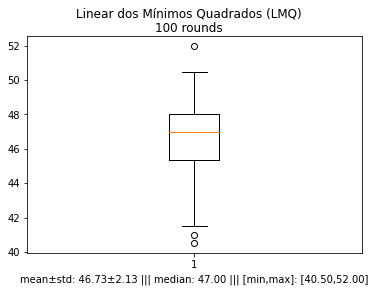

{'name': 'LMQ',
 'mean': 46.73,
 'std': 2.1347365176995496,
 'median': 47.0,
 'min': 40.5,
 'max': 52.0,
 'confusion': array([[4669., 5268.],
        [5386., 4677.]]),
 'stats_class': array([{'acc': 0.4673, 'f1_score': 0.46708683473389356},
        {'acc': 0.4673, 'f1_score': 0.4675129948020792}], dtype=object),
 't_train': 33.042192459106445,
 't_test': 44.2509651184082}

In [ ]:
# LMQ_classifier(data)
# AD_classifier(data)
# PL_classifier(data)
# MLP_classifier(data)